# Algorithms Comparaison
___

In this notebook, we conduct a comprehensive comparison between our custom algorithm and established clustering techniques such as original KMeans, Louvain, and Iterated Greedy. We evaluate these methods based on execution time, modularity, Normalized Mutual Information (NMI), and the number of communities generated, to assess performance and effectiveness across various metrics.


In [15]:
from utils.utils import *
from utils.communities_network import *
from utils.iterative_greedy_algorithm import IG
from utils.kmeans import * 
from utils.visualization import *
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import time

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
output_animation_path = "output/animations"
algorithms_trace = []

## Test Sur Dataset Karate

In [18]:
algorithms_trace = []

### Reading data

In [19]:

file_path = 'data/reel/karate/karate.gml'
G = nx.read_gml(file_path, label='id')
original_nodes = list(G.nodes())
mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, mapping)
adj_matrix = nx.to_numpy_array(G)
true_labels = read_community_labels_file_reel(
    'data/reel/karate/groundTruth.txt')
print(f"The graph contains {adj_matrix.shape[0]} nodes.")

The graph contains 34 nodes.


In [20]:

start_time = time.time()
Cmax, Qmax, Kbest, Labels, trace = local_expansion_kmeans(G, adj_matrix, 2, 10 , metric="QSim")
end_time = time.time()


for item in trace:
    item["NMI"] = calc_nmi(true_labels, communities_to_labels(
        G, item["communities"], original_nodes))


new_methode_time = end_time - start_time
new_methode_modularity = trace[Kbest-2]["Modularity"]
new_methode_nmi = trace[Kbest-2]["NMI"]
new_methode_nb_communities = len(Cmax)


algorithms_trace.append({"name": "Local Expansion Kmeans *", "duration": new_methode_time, "modularity": new_methode_modularity,
                        "nmi": new_methode_nmi, "nb_communities": new_methode_nb_communities})


custom_df_styling(trace) 

No more nodes to select , k is too large


K,Modularity,Similarity-Based Modularity,NMI
2,0.371466,0.210634,1.000000
3,0.228468,0.139135,0.733340
4,0.187295,0.118549,0.522512


#### Iterated Greedy

In [21]:

start_time = time.time()
communitites, modularity_trace, _, _ = IG(adj_matrix, 15, 0.5)
end_time = time.time()

ig_nmi = calc_nmi(true_labels, communities_to_labels(
    G, communitites, original_nodes))
ig_mod = modularity_trace[-1]
ig_time = end_time - start_time
ig_nb_communities = len(communitites)

algorithms_trace.append({"name": "IG", "duration": ig_time , "modularity":ig_mod, "nmi":ig_nmi, "nb_communities":ig_nb_communities})

IG:   0%|          | 0/15 [00:00<?, ?it/s]

#### louvain

In [22]:
start = time.time()
partition, mod = louvain(G)
end = time.time()

louvain_nmi = calc_nmi(true_labels, partition.items())
louvain_time = end - start
louvain_mod = mod
louvain_nb_communities = len(set(partition.values()))

algorithms_trace.append({"name": "Louvain", "duration": louvain_time, "modularity": louvain_mod,
                        "nmi": louvain_nmi, "nb_communities": louvain_nb_communities})

#### kmeans++

In [23]:
start_time = time.time()
Cmax, Qmax, Kbest, Labels, trace = kmeans_random(G, adj_matrix, 2, 10)

end_time = time.time()


for item in trace:
    item["NMI"] = calc_nmi(true_labels, communities_to_labels(
        G, item["communities"], original_nodes))

kmeans_time = end_time - start_time
kmeans_modularity = Qmax
kmeans_nmi = trace[Kbest-2]["NMI"]
kmeans_nb_communities = len(Cmax)

algorithms_trace.append({"name": "Kmeans", "duration": kmeans_time , "modularity":kmeans_modularity, "nmi":kmeans_nmi, "nb_communities":kmeans_nb_communities})

## Drawing Different Results

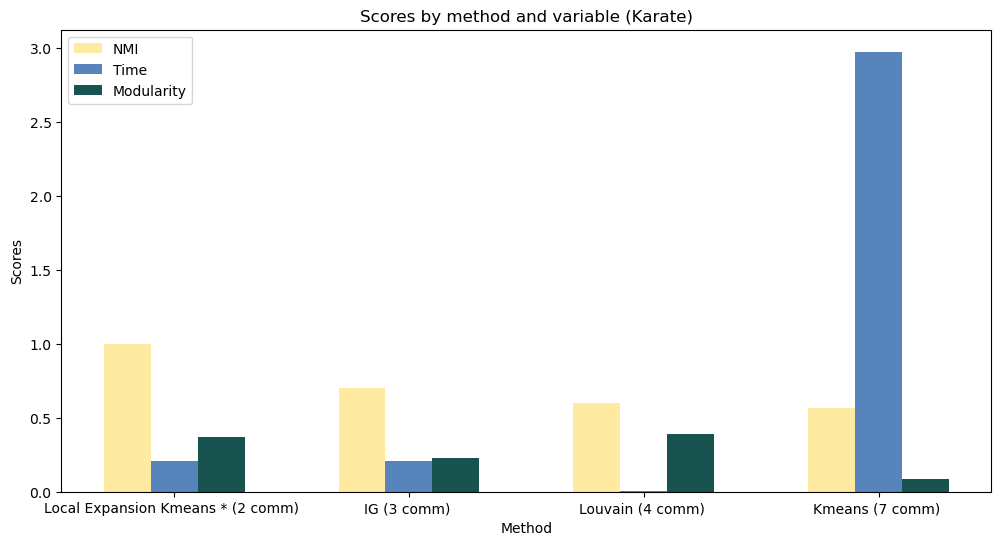

In [24]:
# Sample data
n_groups = len(algorithms_trace)
# NMI for Louvain, IG, New Method
nmi = [algo["nmi"] for algo in algorithms_trace]
# Time for Louvain, IG, New Method
duration = [algo["duration"] for algo in algorithms_trace]
# Modularity for Louvain, IG, New Method
modularity = [algo["modularity"] for algo in algorithms_trace]

# Create plot

fig, ax = plt.subplots(figsize=(12, 6))

index = np.arange(n_groups)
bar_width = 0.2


rects1 = plt.bar(index, nmi, bar_width,
                 color='#FEEAA1',
                 label='NMI')

rects2 = plt.bar(index + bar_width, duration, bar_width,
                 color='#5784BA',
                 label='Time')

rects3 = plt.bar(index + 2 * bar_width, modularity, bar_width,
                 color='#18534F',
                 label='Modularity')


plt.xlabel('Method')
plt.ylabel('Scores')
plt.title('Scores by method and variable (Karate)')


plt.xticks(index + bar_width,
           [f"{algo['name']} ({algo['nb_communities']} comm) " for algo in algorithms_trace])

plt.legend()
plt.show()


- **Local Expansion Kmeans**: This method stands out for achieving the best Normalized Mutual Information (NMI) score, which implies it is most closely aligned with the true community structure in the data.
- **Louvain**: The Louvain method is shown to be superior in terms of computational efficiency, having the lowest execution time. Additionally, it scores highest on modularity, indicating that it effectively maximizes within-community edges and minimizes between-community edges.
- **Iterated Greedy (IG)**: The Iterated Greedy method displays a balanced performance, with NMI and modularity scores that are moderate and better than the standard KMeans, while also maintaining a reasonable execution time.
- **Kmeans (7 comm)**: The KMeans algorithm, with random initial seeds, has the least favorable outcomes in the analysis. It exhibits the longest execution time and the lowest scores in both NMI and modularity, suggesting it is the least suitable method for detecting communities in the given dataset.

In summary, the Local Expansion Kmeans excels in accurately reflecting the community structure, Louvain is the most efficient and effective in terms of modularity, Iterated Greedy offers a compromise between accuracy and efficiency, and the standard KMeans algorithm is outperformed by the other methods in all the metrics considered for community detection.